In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import pickle
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, Conv1D, MaxPooling1D, BatchNormalization, GlobalMaxPooling1D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from keras.layers import LeakyReLU
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Disable warnings
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

# Check TensorFlow version
print(tf.__version__)

# Check for GPU availability
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2.15.0
Num GPUs Available:  1


In [2]:
# Load data from JSON file
def load_data(filepath):
    return pd.read_json(filepath)

# Preprocess data
def preprocess_data(df):
    df['label'] = df['label'].replace('language', 'general')
    df['instruction'] = df['instruction'].apply(lambda x: x.strip())
    return df

def view_data_balance(df, label_col):
    # Count the number of samples in each class
    class_counts = df[label_col].value_counts()
    # Create a bar plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x=class_counts.index, y=class_counts.values)
    plt.xlabel(label_col)
    plt.ylabel('Count')
    plt.title('Class Distribution')
    plt.show()
    return class_counts

# Create a balanced dataset
def balance_data(df, label_col, n_samples):
    samples = [df[df[label_col] == label][:n_samples] for label in df[label_col].unique()]
    return pd.concat(samples)

# create a function to shuffle the dataframe
def shuffle_dataframe(df):
    return df.sample(frac=1).reset_index(drop=True)

# vocabulary size
def calculate_vocabulary_size(df, column_name):
    # Tokenize the text into words
    words = df[column_name].str.split().explode().unique()
    # Count the number of unique words
    vocabulary_size = len(words)
    return vocabulary_size

#max_len calculator
def calculate_max_length(df, column_name):
    # Calculate the maximum length of any text entry in the specified column
    max_len = df[column_name].str.split().apply(len).max()
    return max_len

# Tokenization and padding
def tokenize_and_pad(texts, max_len, num_words):
    tokenizer = Tokenizer(num_words=num_words, oov_token="<UNK>")
    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')
    return tokenizer, padded_sequences

# Build the model
def create_model(input_shape, num_classes):
    model = Sequential([
        Embedding(input_dim=41773, output_dim=128, input_length=input_shape),
        Conv1D(256, 3, padding='same', kernel_regularizer=l2(0.03)),
        LeakyReLU(alpha=0.1),
        BatchNormalization(),
        MaxPooling1D(2),
        Dropout(0.6),
        Conv1D(48, 3, padding='same', kernel_regularizer=l2(0.02)),
        LeakyReLU(alpha=0.1),
        BatchNormalization(),
        MaxPooling1D(2),
        Dropout(0.45),
        GlobalMaxPooling1D(),
        Dense(192, kernel_regularizer=l2(0.02)),
        LeakyReLU(alpha=0.1),
        BatchNormalization(),
        Dropout(0.55),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Train the model
def train_model(model, X_train, y_train, X_validate, y_validate, epochs=30, batch_size=128):
    lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
    early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
    history = model.fit(X_train, y_train, validation_data=(X_validate, y_validate), epochs=epochs, batch_size=batch_size, callbacks=[early_stopping, lr_schedule])
    return history

# Evaluate the model
def evaluate_model(model, X_test, y_test, label_names):
    predictions = model.predict(X_test)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(y_test, axis=1)
    print(classification_report(true_classes, predicted_classes, target_names=label_names))
    confusion_mtx = confusion_matrix(true_classes, predicted_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

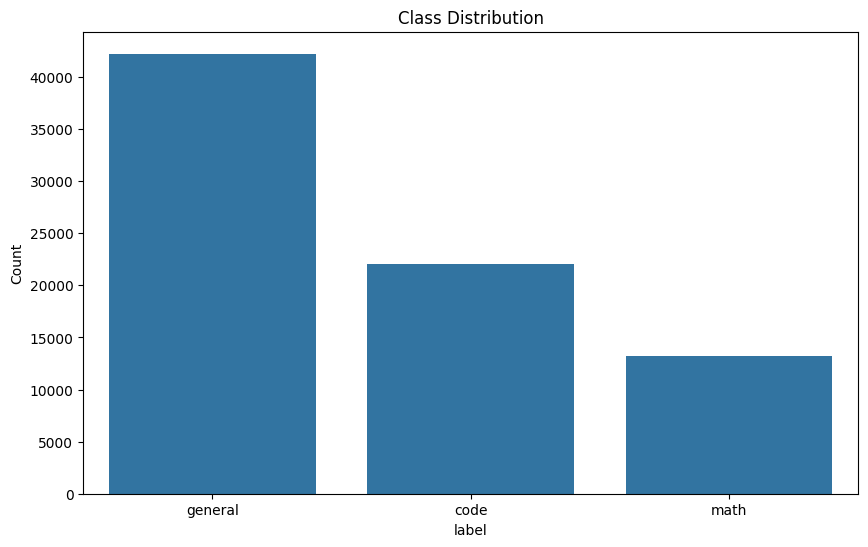

general    42228
code       22009
math       13187
Name: label, dtype: int64


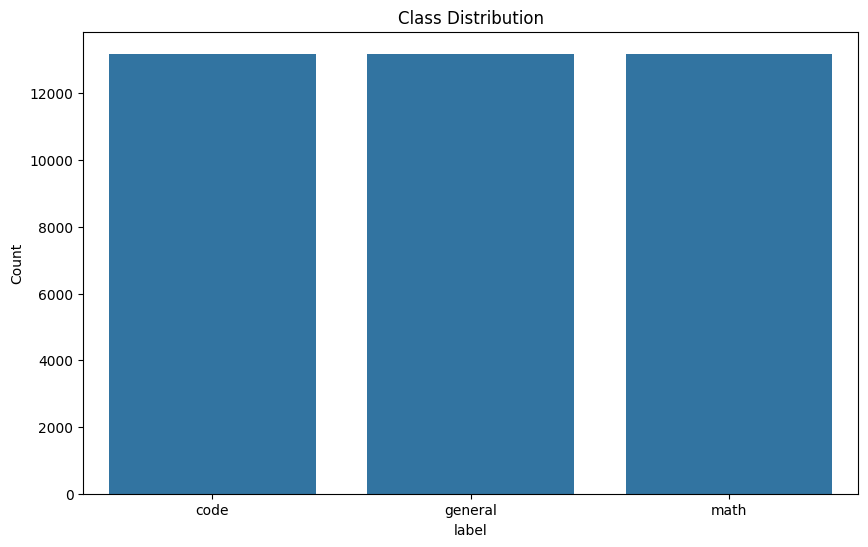

code       13187
general    13187
math       13187
Name: label, dtype: int64
Vocabulary size: 41772
Maximum length: 279
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 279, 128)          5346944   
                                                                 
 conv1d (Conv1D)             (None, 279, 256)          98560     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 279, 256)          0         
                                                                 
 batch_normalization (Batch  (None, 279, 256)          1024      
 Normalization)                                                  
                                                                 
 max_pooling1d (MaxPooling1  (None, 139, 256)          0         
 D)                                                              


2024-05-12 00:23:31.753220: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Max
2024-05-12 00:23:31.753246: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2024-05-12 00:23:31.753255: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2024-05-12 00:23:31.753294: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-12 00:23:31.753310: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


                                                                 
 dropout (Dropout)           (None, 139, 256)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 139, 48)           36912     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 139, 48)           0         
                                                                 
 batch_normalization_1 (Bat  (None, 139, 48)           192       
 chNormalization)                                                
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 69, 48)            0         
 g1D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 69, 48)            0         
                                                                 
 global_ma

2024-05-12 00:23:32.687300: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


186/186 [==============================] - 88s 466ms/step - loss: 5.9037 - accuracy: 0.6377 - val_loss: 4.8522 - val_accuracy: 0.3332 - lr: 0.0010
Epoch 2/30
186/186 [==============================] - 86s 464ms/step - loss: 1.6428 - accuracy: 0.8859 - val_loss: 3.0464 - val_accuracy: 0.3332 - lr: 0.0010
Epoch 3/30
186/186 [==============================] - 86s 464ms/step - loss: 0.6735 - accuracy: 0.9184 - val_loss: 1.8091 - val_accuracy: 0.3332 - lr: 0.0010
Epoch 4/30
186/186 [==============================] - 86s 464ms/step - loss: 0.4240 - accuracy: 0.9260 - val_loss: 0.6375 - val_accuracy: 0.8357 - lr: 0.0010
Epoch 5/30
186/186 [==============================] - 86s 463ms/step - loss: 0.3356 - accuracy: 0.9299 - val_loss: 0.4234 - val_accuracy: 0.9050 - lr: 0.0010
Epoch 6/30
186/186 [==============================] - 86s 465ms/step - loss: 0.3045 - accuracy: 0.9346 - val_loss: 0.4256 - val_accuracy: 0.9008 - lr: 0.0010
Epoch 7/30
186/186 [==============================] - 85s 455ms

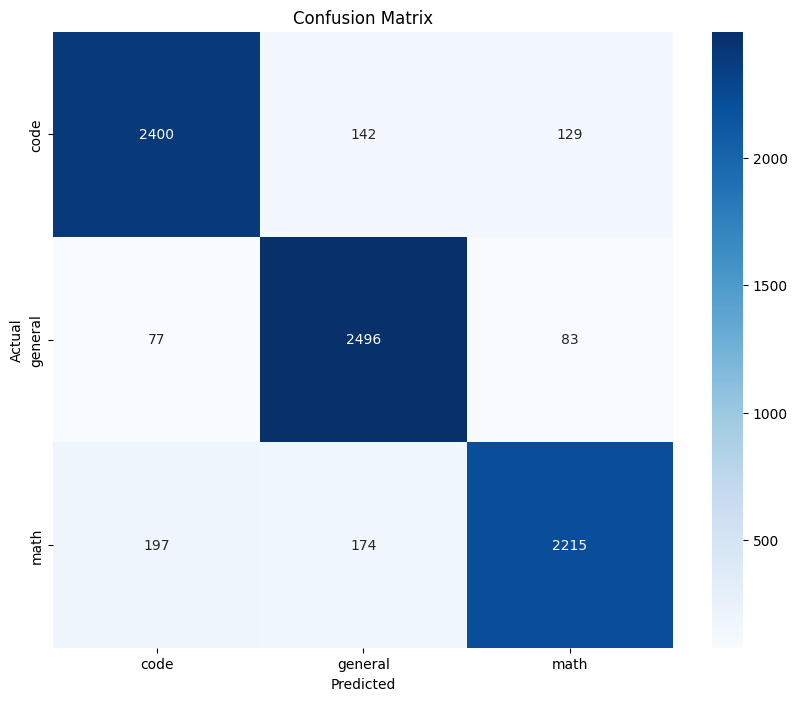

In [3]:
# Main execution block
if __name__ == "__main__":
    # Load and preprocess data
    df = load_data('data/prompts.json')
    df = preprocess_data(df)

    # view data balance
    class_counts = view_data_balance(df, 'label')
    print(class_counts)
    
    # based on the data balance, create a balanced dataset of the same size as the smallest class = 13187
    df = balance_data(df, 'label', 13187)
    
    # shuffle the dataframe
    df = shuffle_dataframe(df)
    df = shuffle_dataframe(df)
    
    # view data balance
    class_counts = view_data_balance(df, 'label')
    print(class_counts)

    # calculate the vocabulary size and max_len
    vocabulary_size = calculate_vocabulary_size(df, 'instruction')
    print(f'Vocabulary size: {vocabulary_size}')

    max_len = calculate_max_length(df, 'instruction')
    print(f'Maximum length: {max_len}')

    # Tokenization and encoding labels
    tokenizer, X_padded = tokenize_and_pad(df['instruction'],max_len,vocabulary_size)
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(df['label'])
    y_categorical = to_categorical(y_encoded)

    # Splitting the dataset
    X_train, X_test, y_train, y_test = train_test_split(X_padded, y_categorical, test_size=0.2, random_state=42)
    X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

    # Model creation and training
    model = create_model(X_train.shape[1], y_train.shape[1])
    model.summary()
    history = train_model(model, X_train, y_train, X_validate, y_validate)

    # Model evaluation
    evaluate_model(model, X_test, y_test, label_encoder.classes_)

In [4]:
model.save('model_weights.h5')

with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('label_encoder.pickle', 'wb') as handle:
    pickle.dump(label_encoder, handle, protocol=pickle.HIGHEST_PROTOCOL)
    